### Run basic `scanpy` QC and doublet detection with `scrublet` for **PBMC Tuberculosis** _Nathan et al 2021_

- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Mairi McClean
- **Computational Health Centre - Helmholtz Munich**
- ORIGINAL: v221101; MODIFIED: v221117

### Load required modules

In [3]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
google              NA
h5py                3.6.0
hypergeom_ufunc     NA
ipykernel           6.16.2
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.39.1
matplotlib          3.6.1
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources

### Read datasets

In [5]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/Lung_TB_T_Cells_CITESEQ_RNA.h5ad')
adata

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [6]:
adata.obs['donor'].value_counts()

TB6692076    5487
TB6361266    5403
TB0763419    4489
TB5758296    4225
TB6448199    4224
             ... 
TB8805781     234
TB0414005     234
TB8797251     202
TB5742418     114
TB4817029      72
Name: donor, Length: 259, dtype: int64

In [7]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

### Filter cells with less than 200 genes

In [8]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

500089 33538


In [9]:
sample_object.shape

(500089, 33538)

In [10]:
sample_object.var

Empty DataFrame
Columns: []
Index: [MIR1302-2HG, FAM138A, OR4F5, AL627309.1, AL627309.3, AL627309.2, AL627309.4, AL732372.1, OR4F29, AC114498.1, OR4F16, AL669831.2, AL669831.5, FAM87B, LINC00115, FAM41C, AL645608.7, AL645608.3, AL645608.5, AL645608.1, SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1, AL645608.8, HES4, ISG15, AL645608.2, AGRN, AL645608.9, RNF223, C1orf159, LINC01342, AL390719.2, TTLL10-AS1, TTLL10, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, AL162741.1, UBE2J2, LINC01786, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, MXRA8, AURKAIP1, CCNL2, MRPL20, AL391244.3, ANKRD65, AL391244.2, TMEM88B, LINC01770, VWA1, ATAD3C, ATAD3B, ATAD3A, TMEM240, SSU72, AL645728.1, FNDC10, AL691432.2, MIB2, MMP23B, CDK11B, FO704657.1, SLC35E2B, CDK11A, SLC35E2A, NADK, GNB1, AL109917.1, CALML6, TMEM52, CFAP74, AL391845.2, GABRD, AL391845.1, PRKCZ, AL590822.2, PRKCZ-AS1, FAAP20, AL590822.1, SKI, MORN1, RER1, PEX10, PLCH2, AL139246.1, AL139246.4, PANK4, HES5, ...]

[33538 rows x 0 columns]

### Compute QC stats

In [11]:
sample_object.shape

(500089, 33538)

In [12]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

mt   ribo
MIR1302-2HG  False  False
FAM138A      False  False
OR4F5        False  False
AL627309.1   False  False
AL627309.3   False  False
...            ...    ...
AC233755.2   False  False
AC233755.1   False  False
AC240274.1   False  False
AC213203.1   False  False
FAM231C      False  False

[33538 rows x 2 columns]

In [13]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [14]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1).A1

In [15]:
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC metrics

In [16]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [17]:
sample_object.obs

cell_id  nUMI  nGene  percent_mito  batch TB_status  \
0        AAACCCAAGGCCTAAG-1  6108   1557      0.055828      1      CASE   
1        AAACCCAAGGTTCTTG-1  7902   2149      0.083017      1      CASE   
2        AAACCCAAGTGCAGGT-1  5033   1788      0.129744      1      CASE   
3        AAACCCACAAGAGTAT-1  6574   1747      0.066930      1      CASE   
4        AAACCCACACACGGTC-1  6471   1872      0.047442      1      CASE   
...                     ...   ...    ...           ...    ...       ...   
500084  TTTGTTGTCCGCCTAT-46  1945    833      0.183033     46      CASE   
500085  TTTGTTGTCCTGGGTG-46  4534   1537      0.051610     46   CONTROL   
500086  TTTGTTGTCGATGGAG-46  3157   1013      0.081723     46      CASE   
500087  TTTGTTGTCGTTTACT-46  3675   1202      0.089252     46      CASE   
500088  TTTGTTGTCTCTTCAA-46  9072   2181      0.060185     46   CONTROL   

          UMAP_1    UMAP_2        cluster_name cluster_ids      donor  \
0      -2.743703  1.617194          CD4+ CD27+         C-2  TB3419057   
1      -4.237045  0.306832  CD4+ CCR4+ central         C-3  TB3419057   
2      -1.136187 -4.012949           CD4+ Treg         C-9  TB3419057   
3      -1.015078  3.789505    CD4+ CD27+CD161+         C-4  TB3419057   
4       0.658381  2.427080         CD4+ Th17/1        C-13  TB0610655   
...          ...       ...                 ...         ...        ...   
500084 -2.568426  0.780417          CD4+ CD27+         C-2  TB9334348   
500085  1.017550 -0.594416            CD4+ Th1        C-17  TB2792656   
500086  2.301589  0.623997         CD4+ Th17/1        C-16  TB7198118   
500087  0.572390 -1.264730            CD4+ Th1        C-17  TB9334348   
500088 -3.697227  0.161370  CD4+ CCR4+ central         C-3  TB2496561   

        n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
0          1557               1557        6108.0            341.0   
1          2149               2149        7902.0            656.0   
2          1788               1788        5033.0            653.0   
3          1747               1747        6574.0            440.0   
4          1872               1872        6471.0            307.0   
...         ...                ...           ...              ...   
500084      833                833        1945.0            356.0   
500085     1537               1537        4534.0            234.0   
500086     1013               1013        3157.0            258.0   
500087     1202               1202        3675.0            328.0   
500088     2181               2181        9072.0            546.0   

        pct_counts_mt  total_counts_ribo  pct_counts_ribo  percent_mt2  \
0            5.582842             2469.0        40.422398     0.055828   
1            8.301696             2759.0        34.915211     0.083017   
2           12.974369             1289.0        25.610968     0.129744   
3            6.693033             2674.0        40.675388     0.066930   
4            4.744244             2310.0        35.697727     0.047442   
...               ...                ...              ...          ...   
500084      18.303343              114.0         5.861183     0.183033   
500085       5.161005             1161.0        25.606527     0.051610   
500086       8.172316             1231.0        38.992714     0.081723   
500087       8.925170             1167.0        31.755102     0.089252   
500088       6.018518             3777.0        41.633598     0.060185   

        n_counts  
0         6108.0  
1         7902.0  
2         5033.0  
3         6574.0  
4         6471.0  
...          ...  
500084    1945.0  
500085    4534.0  
500086    3157.0  
500087    3675.0  
500088    9072.0  

[500089 rows x 20 columns]

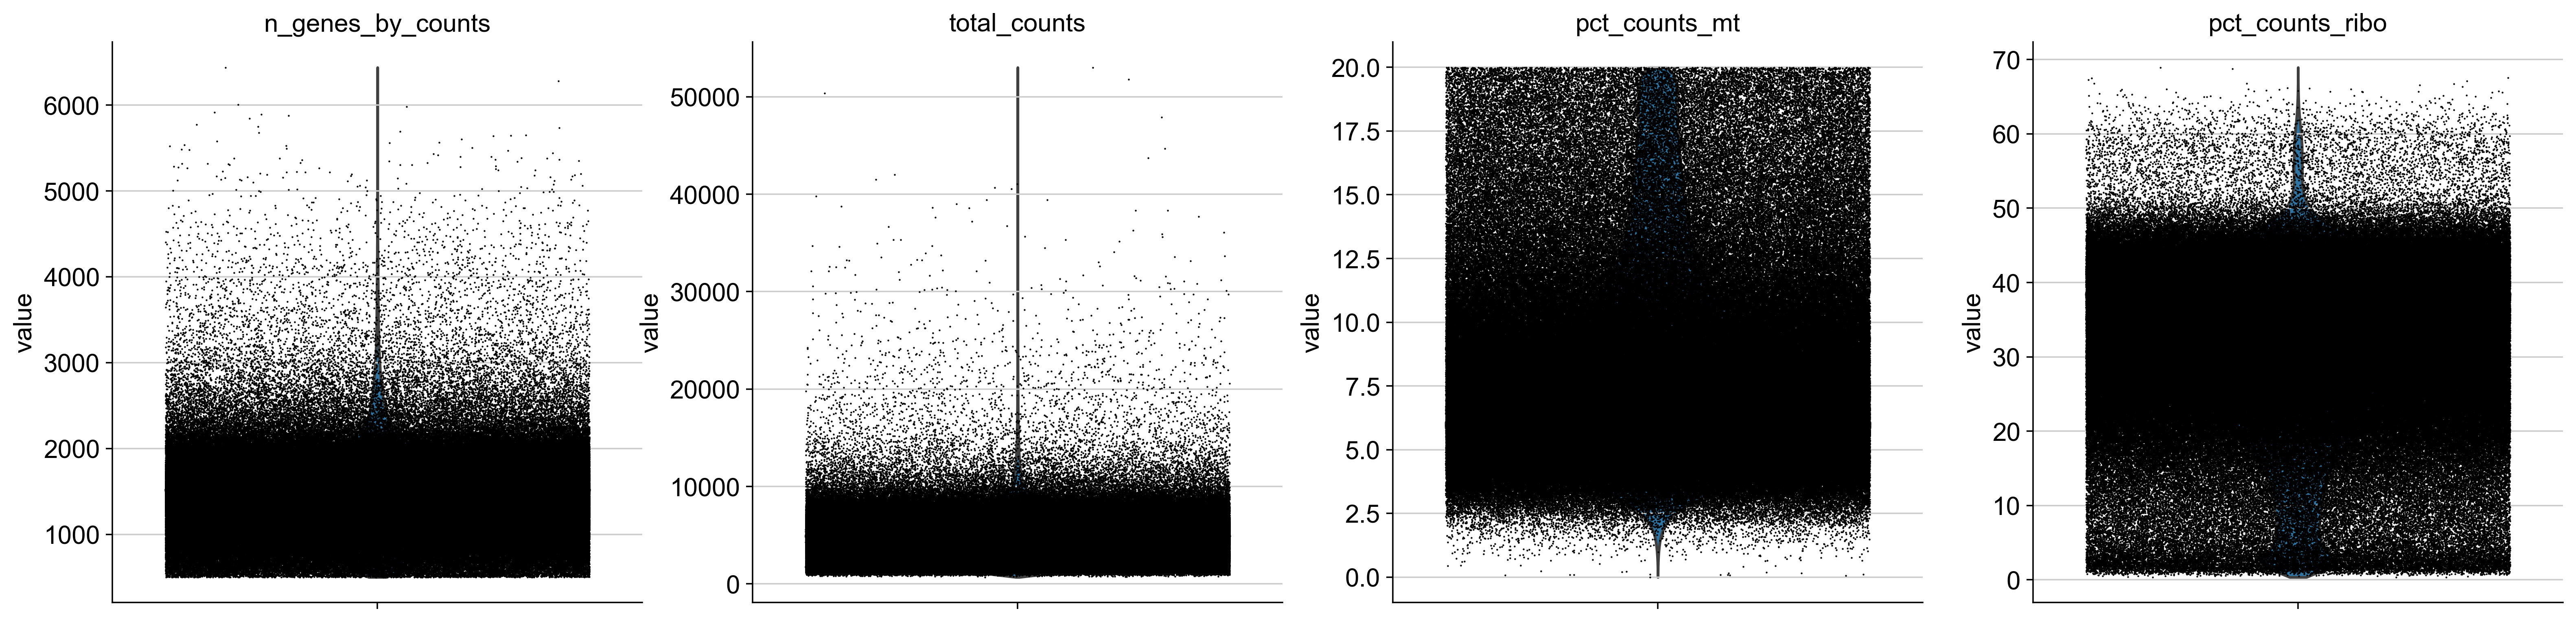

In [20]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

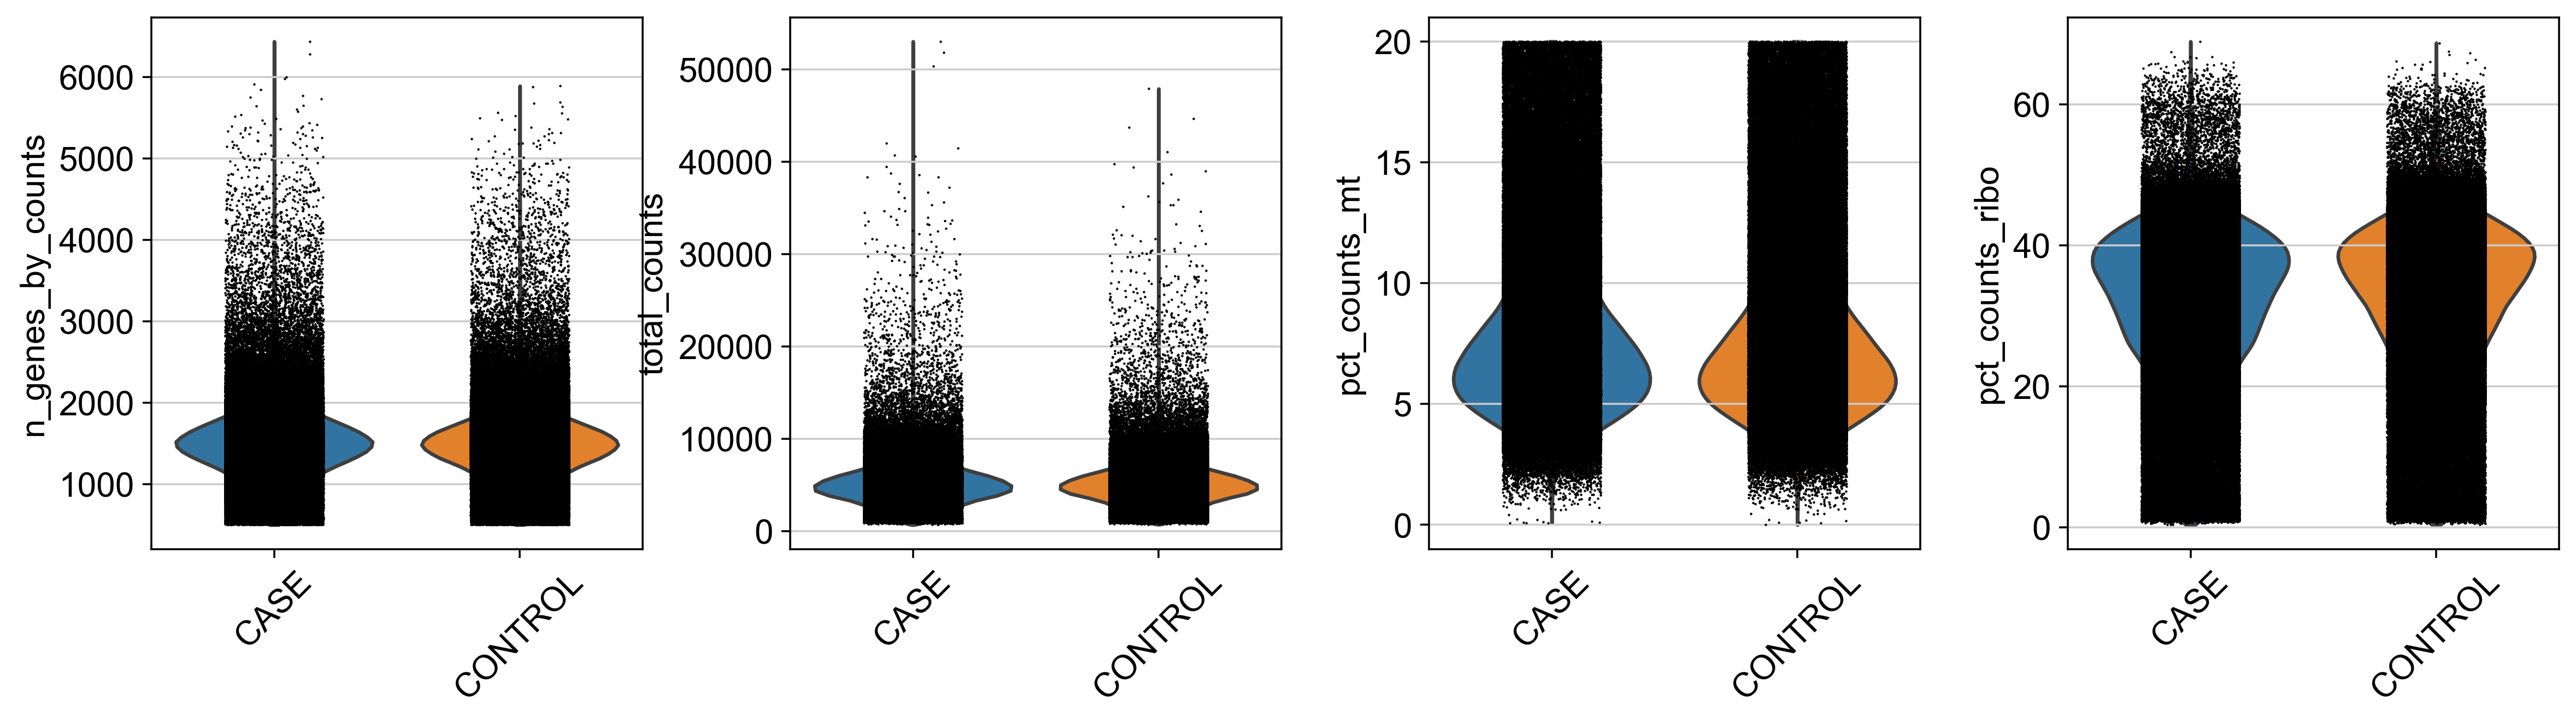

In [18]:
# Organized by disease status as sample size is too large to do by sample

sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

In [23]:
sample_object.obs.value_counts('cluster_ids')

cluster_ids
C-4     45519
C-2     40431
C-17    37566
C-3     28951
C-6     27770
C-7     26701
C-9     25270
C-23    23213
C-11    20696
C-16    20191
C-8     19901
C-19    17731
C-10    17321
C-29    17085
C-12    16987
C-28    15225
C-14    13662
C-13    13216
C-22     9320
C-24     8319
C-30     8144
C-15     8072
C-18     6768
C-25     6398
C-20     5798
C-1      4891
C-26     4343
C-21     4241
C-5      3255
C-27     2508
C-31      336
dtype: int64

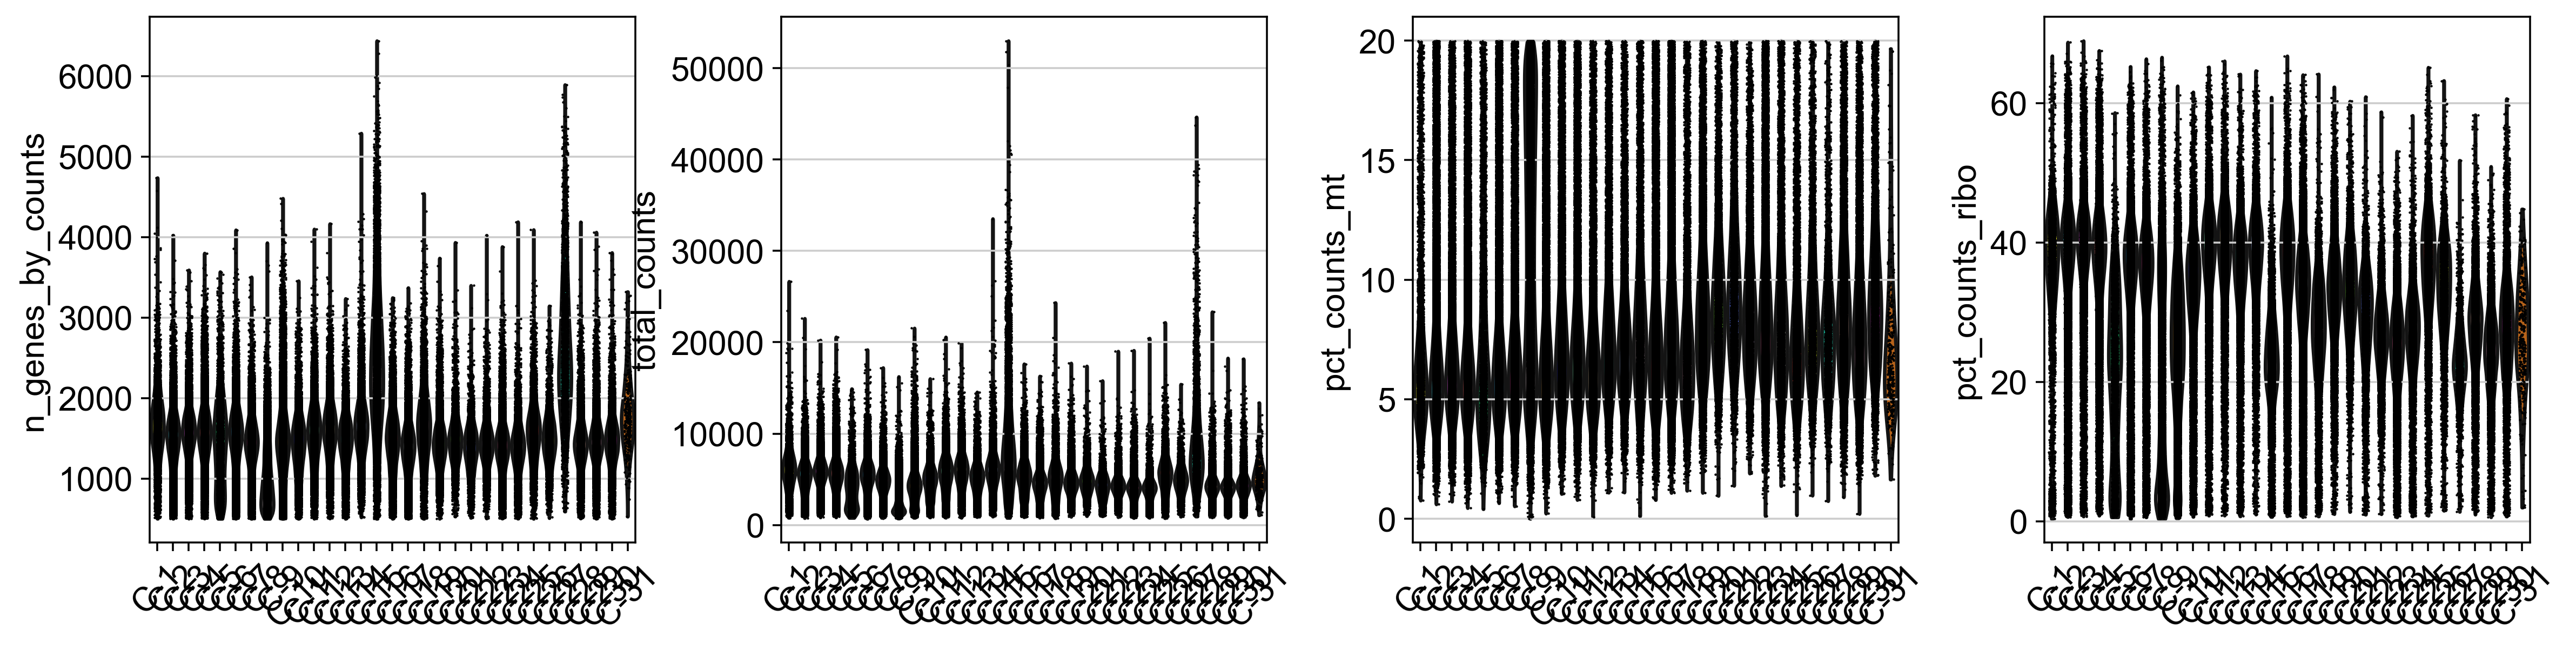

In [25]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'cluster_ids', rotation = 45)

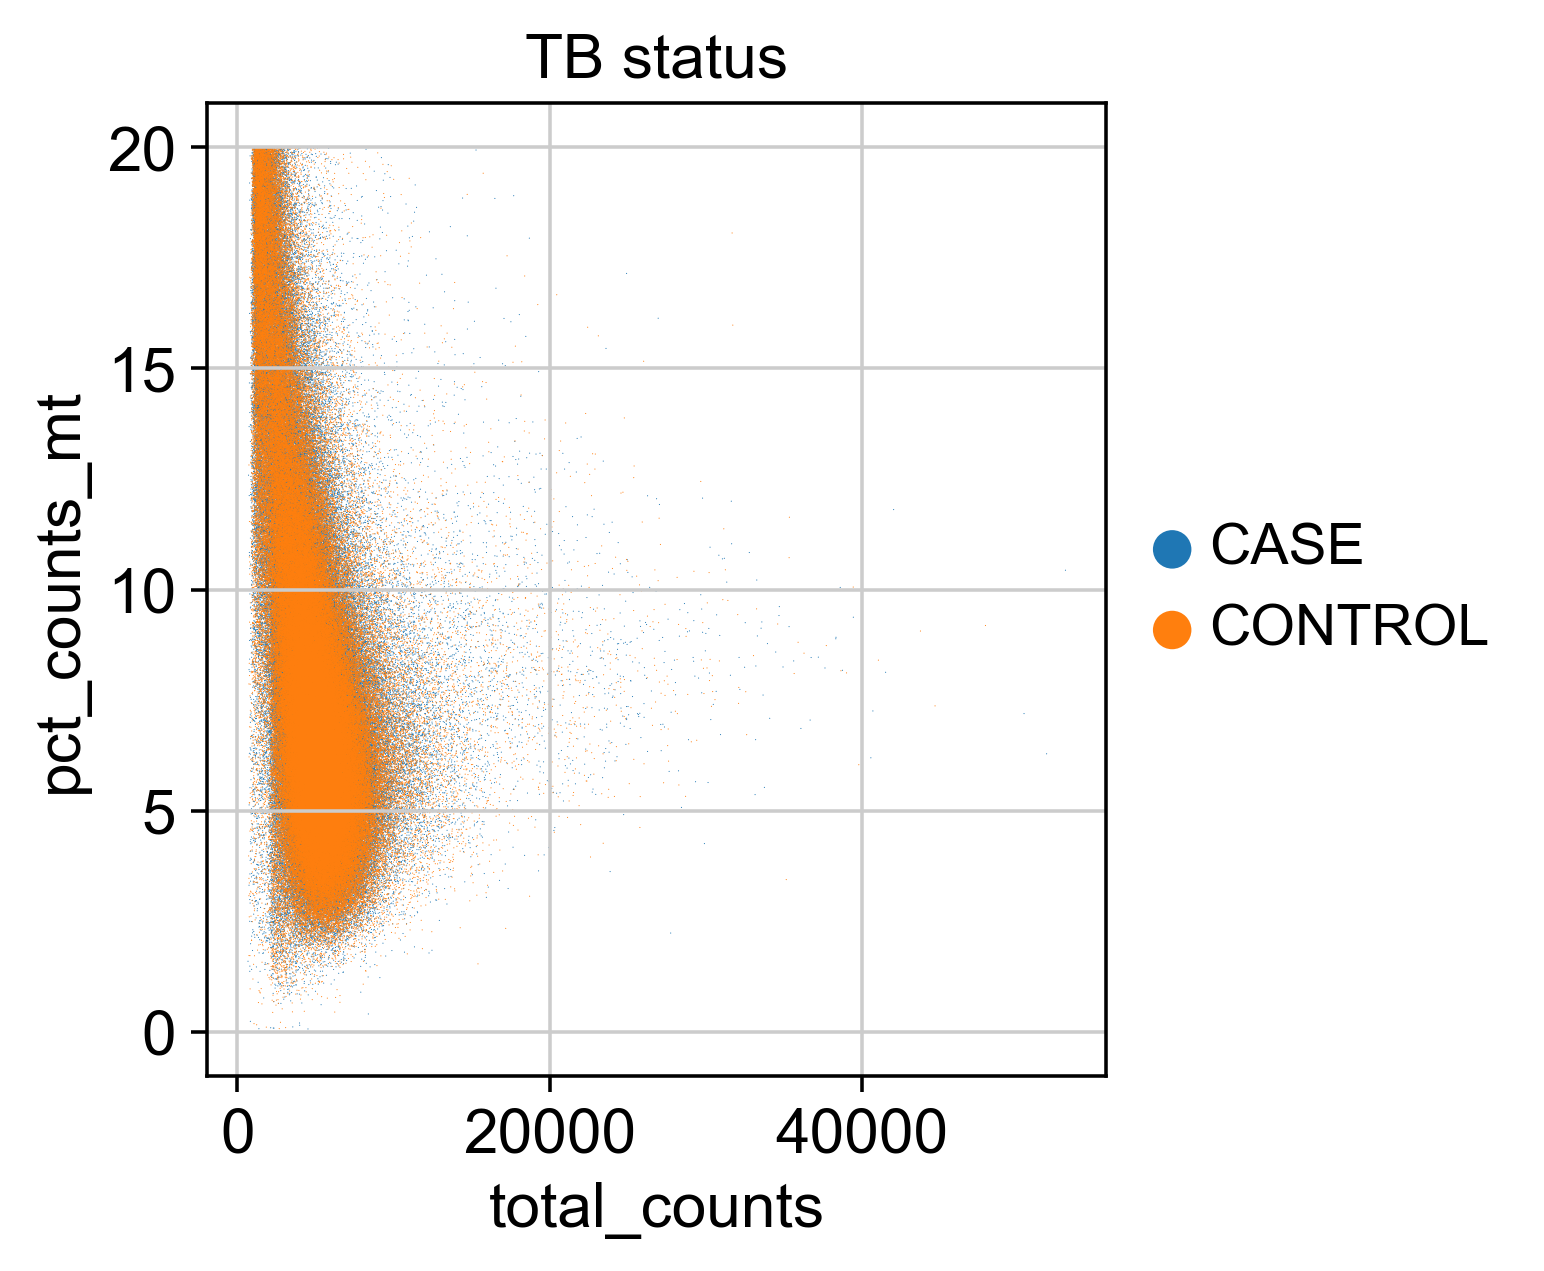

In [26]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "TB_status")

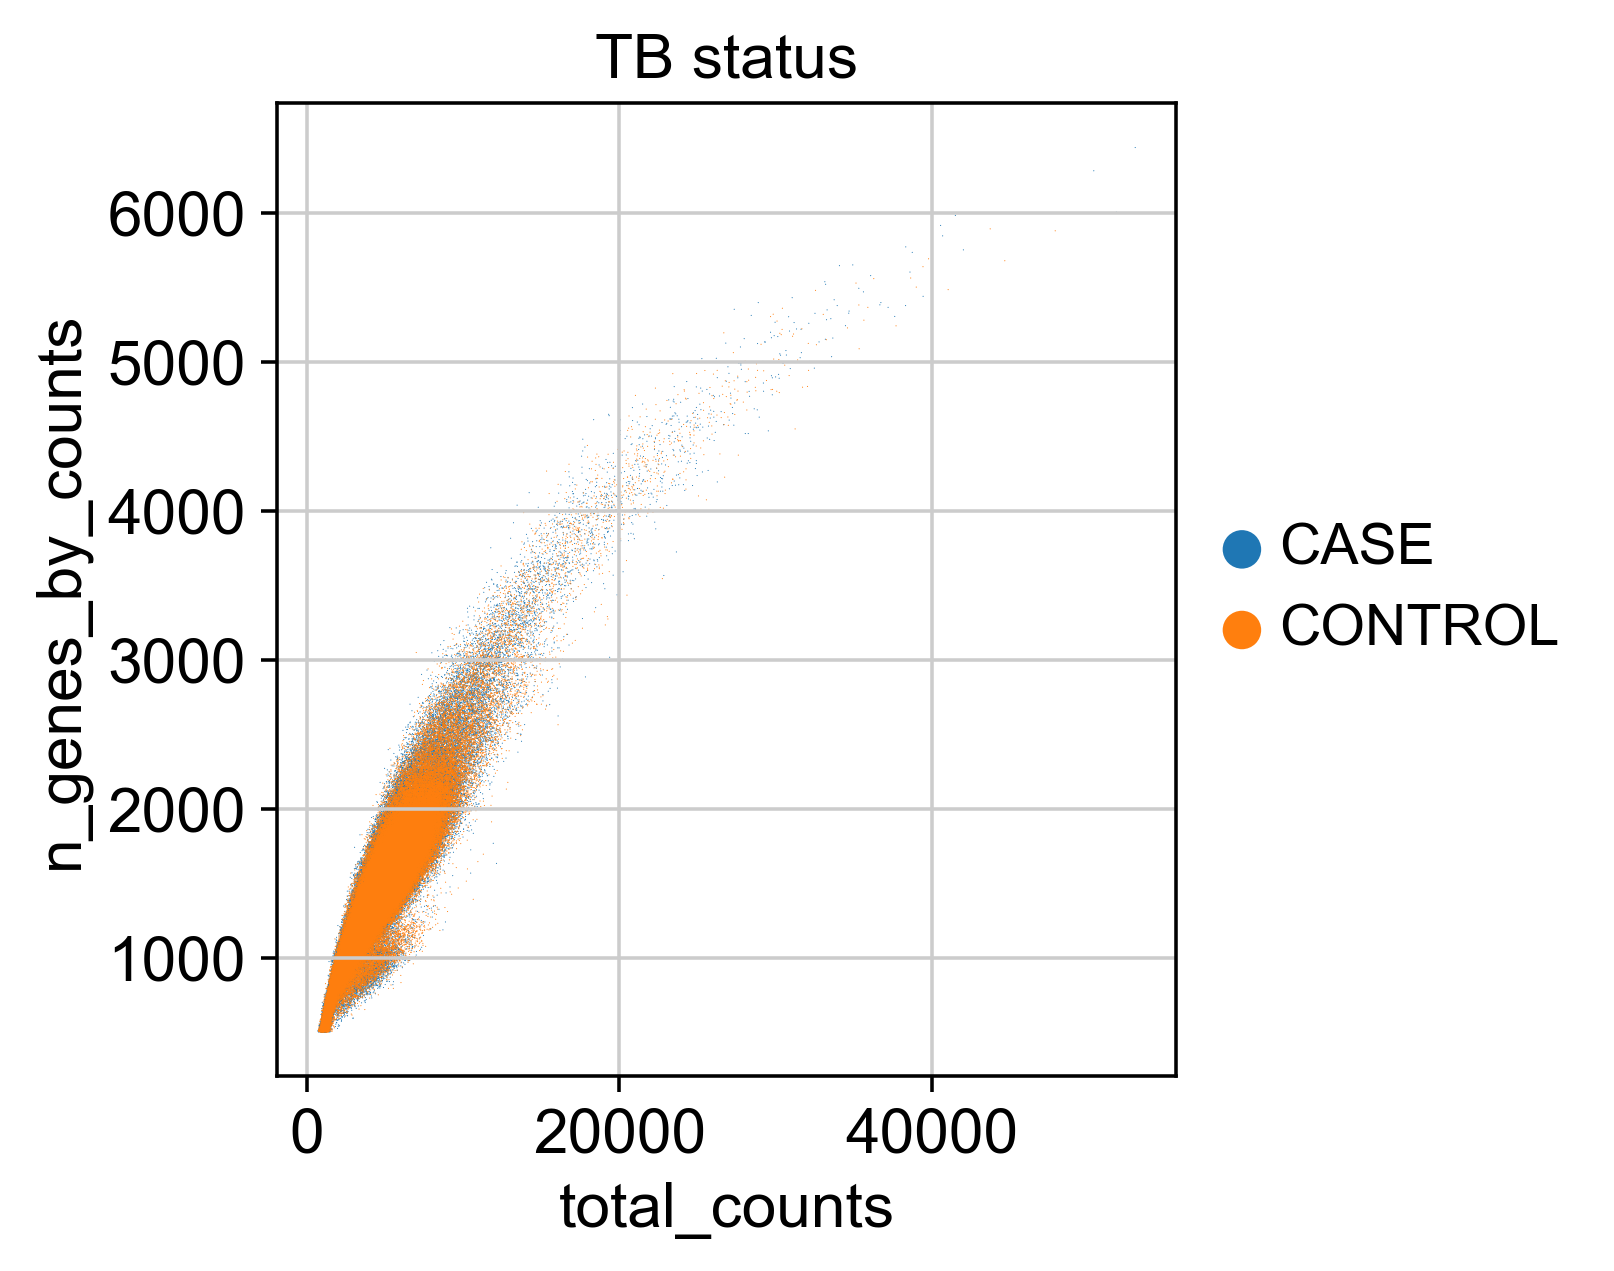

In [27]:
sc.pl.scatter(sample_object, x='total_counts', y='n_genes_by_counts', color = "TB_status")

### Add sample sex covariate

In [31]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [32]:
annot.head()

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                  
MT-TF               ENSG00000210049             577           647   
MT-RNR1             ENSG00000211459             648          1601   
MT-TV               ENSG00000210077            1602          1670   
MT-RNR2             ENSG00000210082            1671          3229   
MT-TL1              ENSG00000209082            3230          3304   

                   chromosome_name  
external_gene_name                  
MT-TF                           MT  
MT-RNR1                         MT  
MT-TV                           MT  
MT-RNR2                         MT  
MT-TL1                          MT

In [33]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['SRY', 'RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'TGIF2LY', 'PCDH11Y',
       'TSPY2', 'LINC00280', 'TTTY1B', 'TTTY2B', 'TTTY21B', 'TTTY7', 'TTTY8B',
       'AMELY', 'TBL1Y', 'TTTY12', 'LINC00279', 'TTTY18', 'TTTY19', 'TTTY11',
       'TTTY20', 'TSPY4', 'TSPY8', 'TSPY3', 'FAM197Y5', 'TSPY1', 'TSPY10',
       'TTTY8', 'TTTY7B', 'TTTY21', 'TTTY2', 'TTTY1', 'TTTY22', 'TTTY23',
       'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'VCY', 'VCY1B', 'NLGN4Y',
       'NLGN4Y-AS1', 'FAM41AY1', 'FAM224B', 'CDY2B', 'CDY2A', 'FAM224A',
       'FAM41AY2', 'HSFY1', 'TTTY9B', 'HSFY2', 'TTTY14', 'KDM5D', 'TTTY10',
       'EIF1AY', 'RPS4Y2', 'PRORY', 'RBMY1B', 'RBMY1A1', 'TTTY13', 'RBMY1D',
       'RBMY1E', 'PRY2', 'TTTY6B', 'RBMY1F', 'TTTY5', 'RBMY1J', 'TTTY6', 'PRY',
       'TTTY17A', 'TTTY4', 'BPY2', 'DAZ1', 'DAZ2', 'TTTY3B', 'CDY1B',
       'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ3', 'DAZ4', 'BPY2C', 'TTTY4C',
       'TTTY17C', 'CDY1', 'TTTY3'],
      dtype='object')

In [34]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

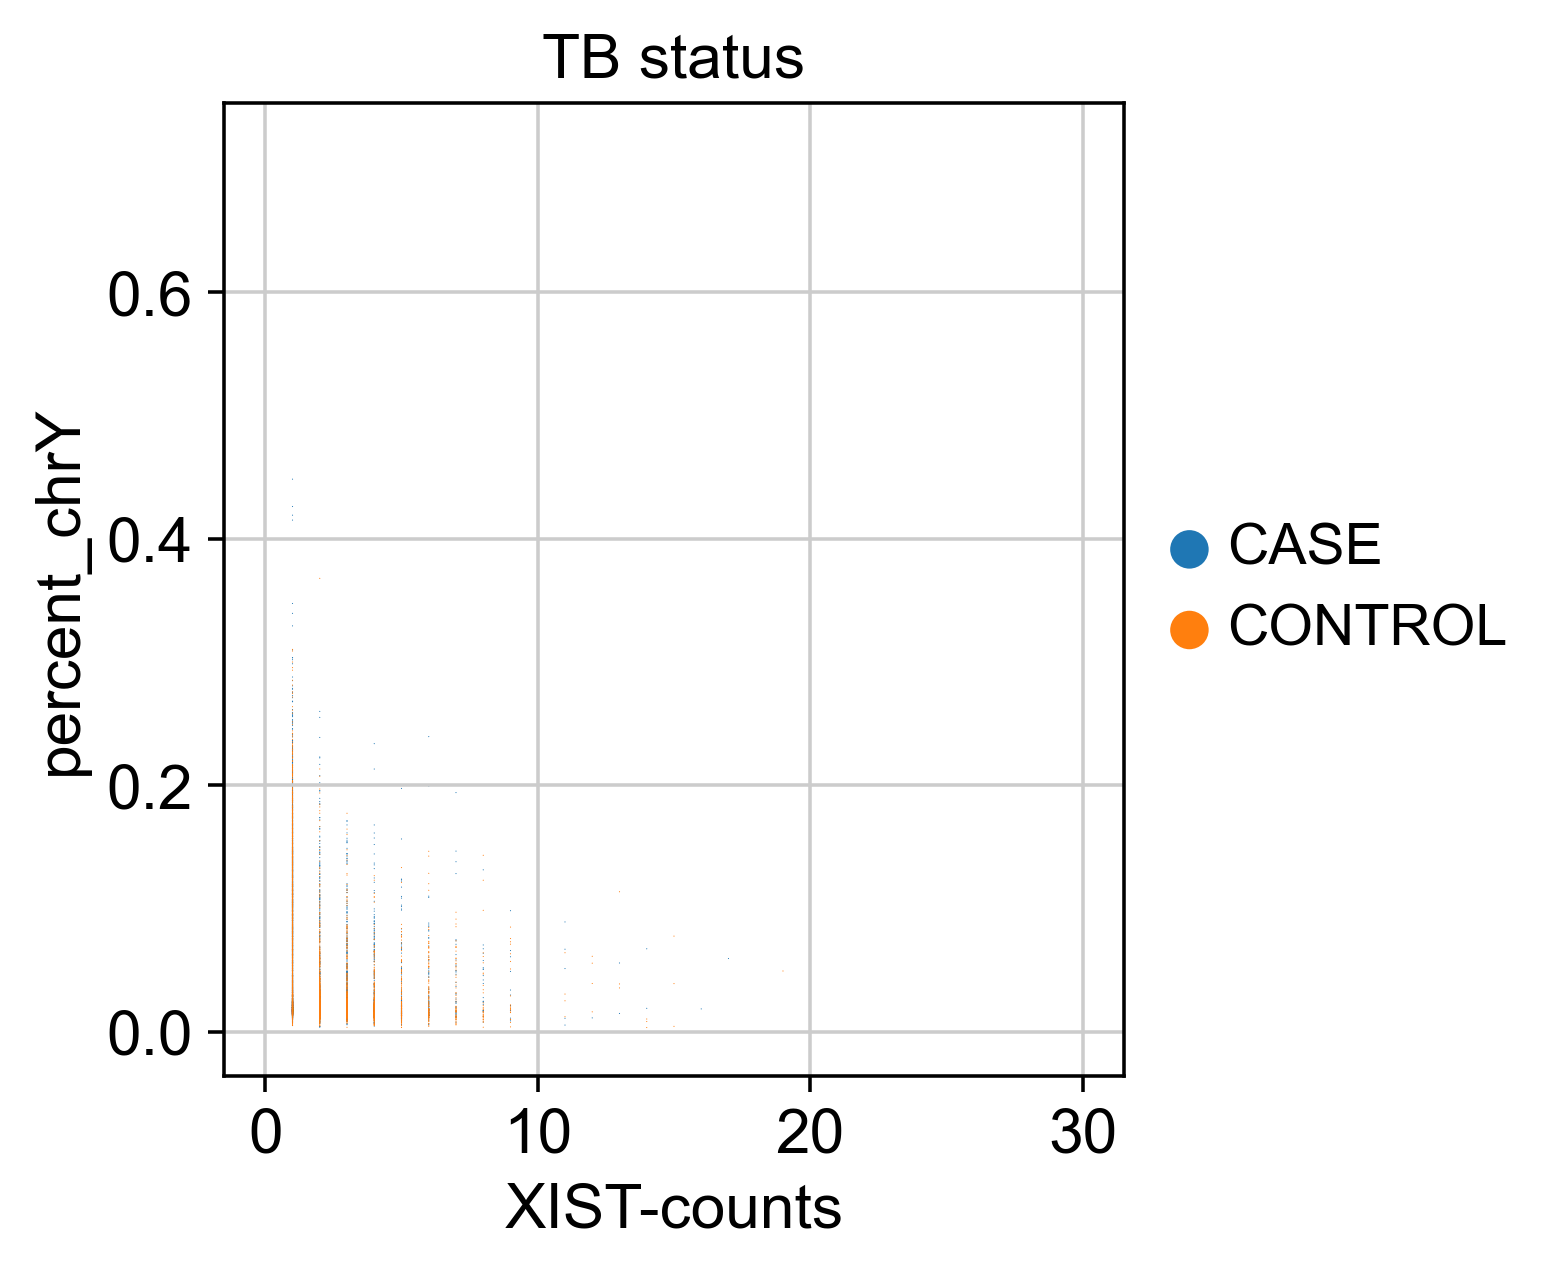

In [36]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "TB_status")

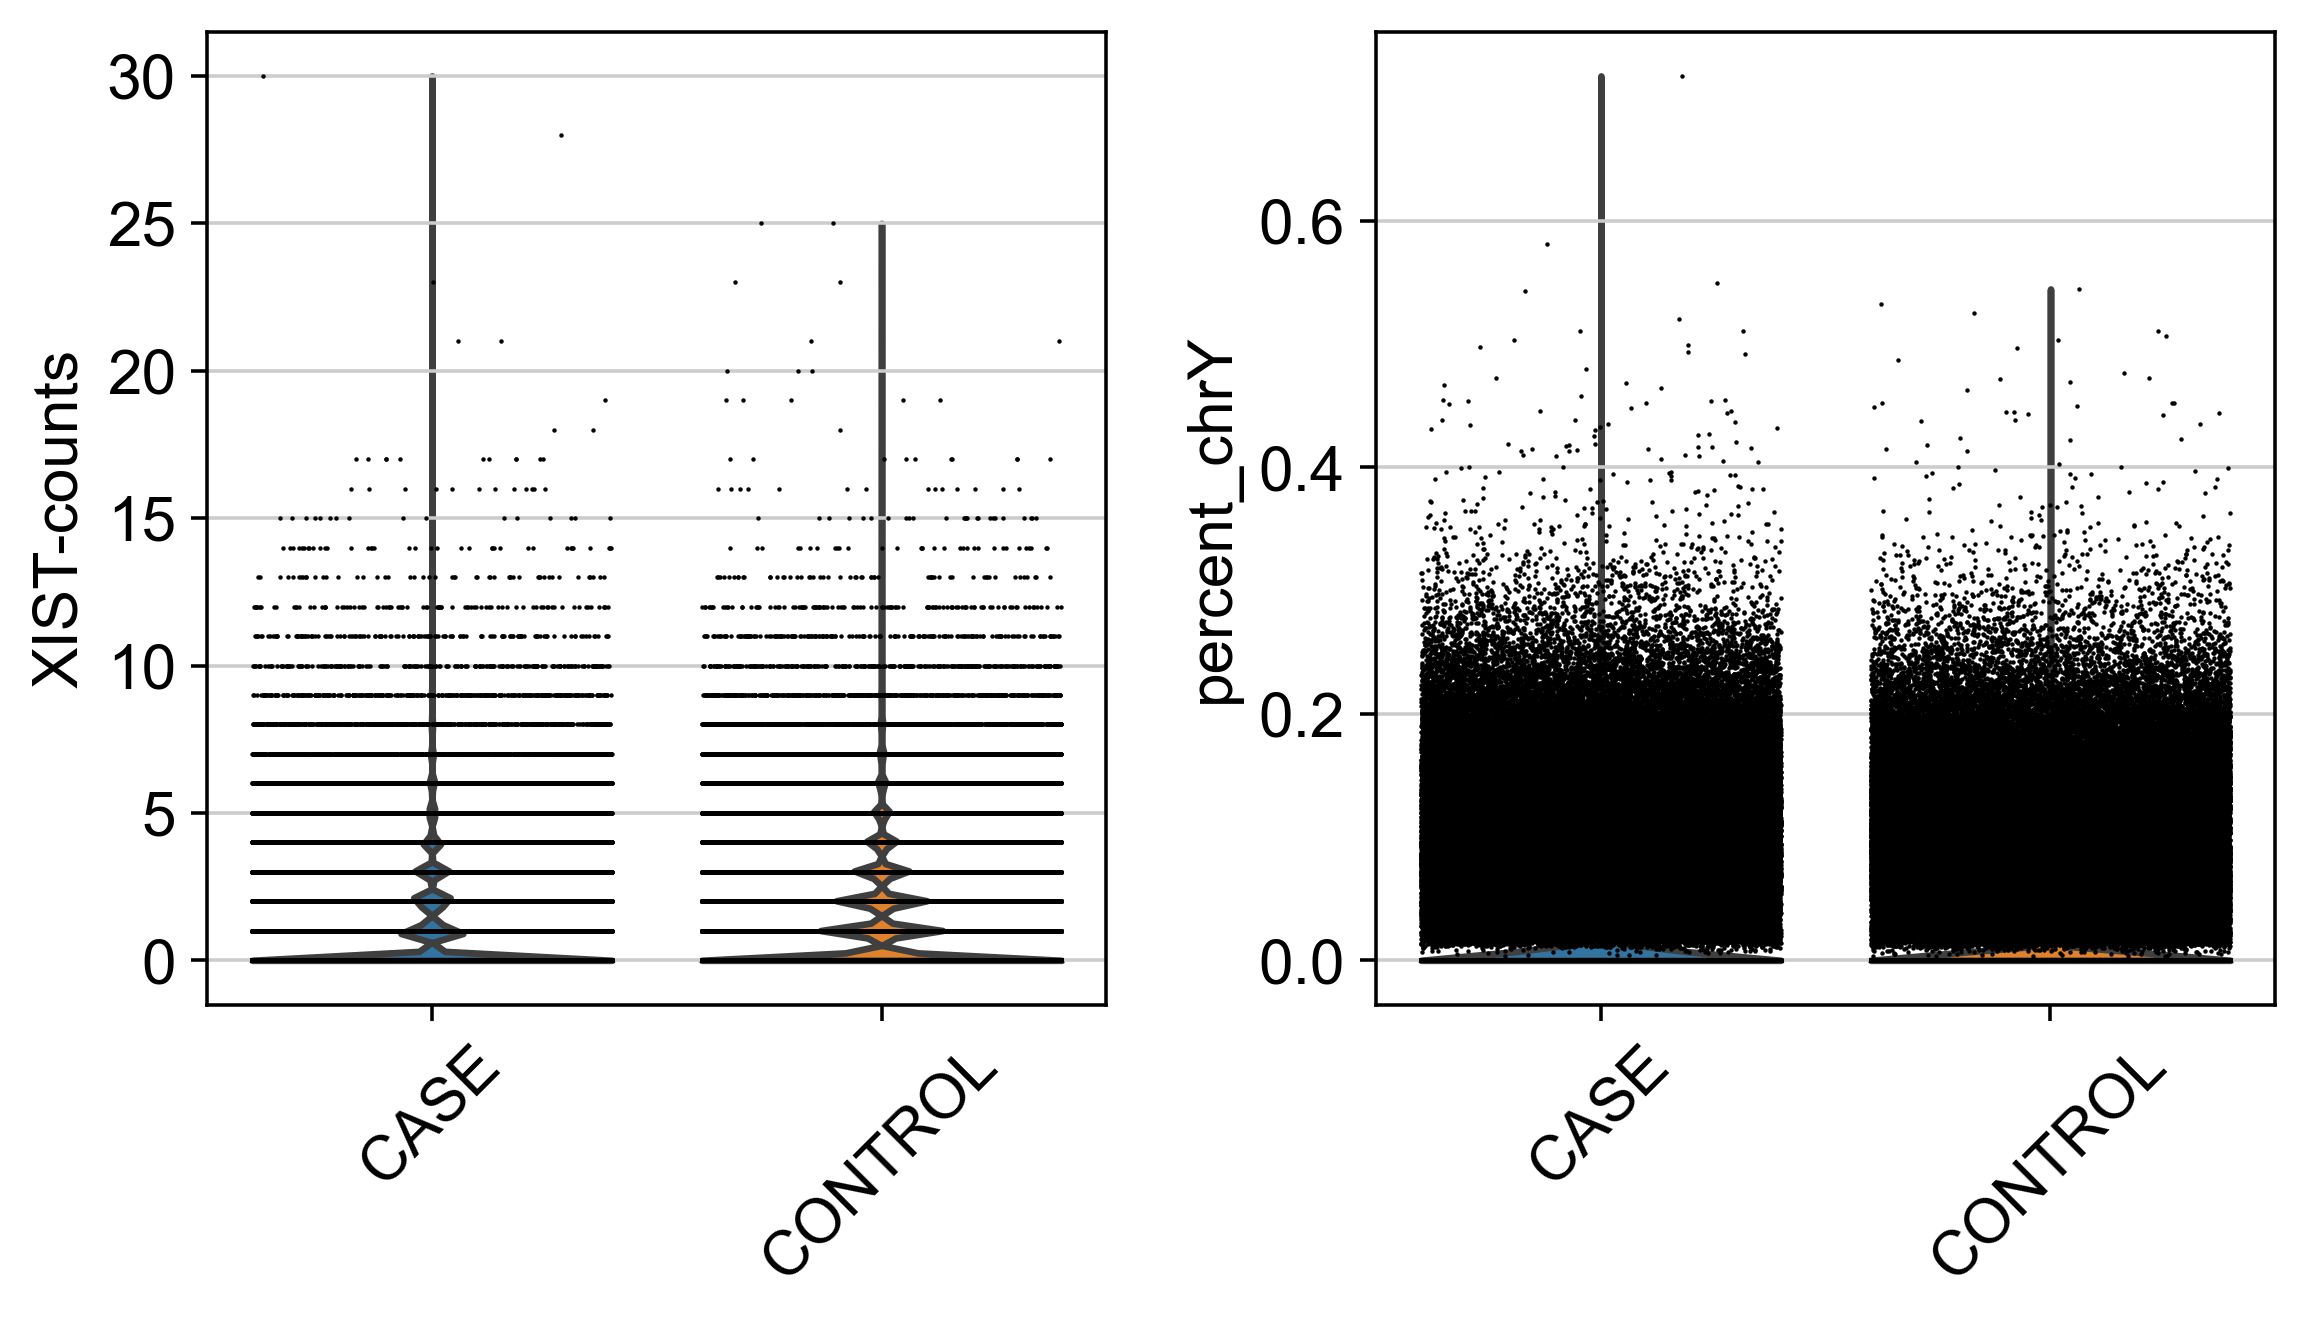

In [37]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'TB_status', rotation = 45)

### Calculate cell cycle scores

In [38]:
!if [ ! -f /Users/mairi.mcclean/cell_cycle_gene.txt ]; then curl -o /Users/mairi.mcclean/cell_cycle_gene.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [39]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/cell_cycle_gene.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [40]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

: 

: 

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'donor', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

### Predict doublets

In [ ]:
scrub = scr.Scrublet(sample_object.X)
sample_object.obs['doublet_scores'], sample_object.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(sample_object.obs['predicted_doublets'])

In [ ]:
#check if our predicted doublets also have more detected genes in general; what would be the number required to raise suspicions?

sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

In [ ]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

### Export object

In [ ]:
sample_object.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/Nathan2021_PBMC_TB_QCed_pre-process_mm221122.h5ad')
